In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Statistical Relational Learning with `pslpython`

In this section we'll explore one form of 
[*statistical relational learning*](../glossary/#statistical-relational-learning)
called 
[*probabilistic soft logic*](../glossary/#probabilistic-soft-logic) (PSL).

One of the examples given for PSL is called [*simple acquaintances*](https://github.com/linqs/psl-examples/tree/master/simple-acquaintances), which uses a graph of some friends, where they live, what interests they share, and then infers who probably knows whom.
Some people explicitly do or do not know each other, while other "knows" relations can be inferred based on whether two people have lived in the same place or share common interest.

The objective is to build a PSL model for [*link prediction*](https://en.wikipedia.org/wiki/Link_prediction), to evaluate the annotations in the friend graph.
In this case, we'll assume that the "knows" relations have been added from a questionable source (e.g., some third-party dataset) so we'll measure a subset of these relations and determine their likelihood.
NB: this is really useful for cleaning up annotations in a large graph!

Now let's load a KG which is an RDF representation of this "simple acquaintances" example, based on using the [`foaf`](http://www.foaf-project.org/) vocabulary:

In [2]:
from os.path import dirname
import kglab
import os

namespaces = {
    "acq":  "http://example.org/stuff/",
    "foaf": "http://xmlns.com/foaf/0.1/",
    }

kg = kglab.KnowledgeGraph(
    name = "LINQS simple acquaintance example for PSL",
    base_uri = "http://example.org/stuff/",
    namespaces = namespaces,
    )

kg.load_rdf(dirname(os.getcwd()) + "/dat/acq.ttl") ;

Take a look at the `dat/acq.ttl` file to see the people and their relations.
Here's a quick visualization of the graph:

In [3]:
VIS_STYLE = {
    "foaf": {
        "color": "orange",
        "size": 5,
    },
    "acq":{
        "color": "blue",
        "size": 30,
    },
}

excludes = [
    kg.get_ns("rdf").type,
    kg.get_ns("rdfs").domain,
    kg.get_ns("rdfs").range,
]

subgraph = kglab.SubgraphTensor(kg, excludes=excludes)
pyvis_graph = subgraph.build_pyvis_graph(notebook=True, style=VIS_STYLE)

pyvis_graph.force_atlas_2based()
pyvis_graph.show("tmp.fig04.html")

## Loading a PSL model

Next, we'll use the [`pslpython`](https://pypi.org/project/pslpython/) library implemented in Python (atop its core library running in Java) to define three *predicates* (i.e., relations – similar as in RDF) which are: `Neighbors`, `Likes`, `Knows`

In [4]:
psl = kglab.PSLModel(
    name = "simple acquaintances",
    )

Then add each of the predicates:

In [5]:
psl.add_predicate("Lived", size=2)
psl.add_predicate("Likes", size=2)
psl.add_predicate("Knows", size=2, closed=False)
;

''

Next, we'll add a set of probabilistic [*rules*](https://psl.linqs.org/wiki/2.2.1/Rule-Specification.html), all with different weights applied:

  1. "Two people who live in the same place are **more** likely to know each other"
  2. "Two people who don't live in the same place are **less** likely to know each other"
  3. "Two people who share a common interest are **more** likely to know each other"
  4. "Two people who both know a third person are **more** likely to know each other"
  5. "Otherwise, any pair of people are **less** likely to know each other"

In [6]:
psl.add_rule("Lived(P1, L) & Lived(P2, L) & (P1 != P2) -> Knows(P1, P2)", weight=20.0, squared=True)

psl.add_rule("Lived(P1, L1) & Lived(P2, L2) & (P1 != P2) & (L1 != L2) -> !Knows(P1, P2)", weight=5.0, squared=True)

psl.add_rule("Likes(P1, L) & Likes(P2, L) & (P1 != P2) -> Knows(P1, P2)", weight=10.0, squared=True)

psl.add_rule("Knows(P1, P2) & Knows(P2, P3) & (P1 != P3) -> Knows(P1, P3)", weight=5.0, squared=True)

psl.add_rule("!Knows(P1, P2)", weight=5.0, squared=True)
;

''

Finally we'll add a [*commutative*](https://mathworld.wolfram.com/Commutative.html) rule such that:
> "If Person 1 knows Person 2, then Person 2 also knows Person 1."

In [7]:
psl.add_rule("Knows(P1, P2) = Knows(P2, P1)", weighted=False) ;

To initialize the model, we'll clear any pre-existing data for each of the predicates:

In [8]:
psl.clear_model() ;

Next we'll create a specific `Subgraph` to transform the names of `foaf:Person` in the graph, since the PSL rules in this example focus on relations among the people:

In [9]:
people_iter = kg.rdf_graph().subjects(kg.get_ns("rdf").type, kg.get_ns("foaf").Person)
people_nodes = [ p for p in sorted(people_iter, key=lambda p: str(p)) ]

subgraph_people = kglab.Subgraph(kg, preload=people_nodes)

Now let's query our KG to populate data into the `Liked` predicate in the PSL model, based on `foaf:based_near` which represents people who live nearby each other:

In [10]:
sparql = """
SELECT DISTINCT ?p1 ?l
  WHERE {
    ?p1 foaf:based_near ?l
  }
"""

for row in kg.query(sparql):
    p1 = subgraph_people.transform(row.p1)
    l = subgraph.transform(row.l)
    psl.add_data_row("Lived", [p1, l])

Note: these data points are *observations*, i.e., empirical support for the probabilistic model.

Next let's query our KG to populate data into the `Likes` predicate in the PSL model, based on shared interests in `foaf:topic_interest` topics:

In [11]:
sparql = """
SELECT DISTINCT ?p1 ?t
  WHERE {
    ?p1 foaf:topic_interest ?t
  }
  """

for row in kg.query(sparql):
    p1 = subgraph_people.transform(row.p1)
    t = subgraph.transform(row.t)
    psl.add_data_row("Likes", [p1, t])

Just for kicks, let's take a look at the internal representation of a PSL predicate, which is a `pandas.DataFrame`:

In [12]:
predicate = psl.model.get_predicate("Likes")
predicate.__dict__

{'_types': [<ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>,
  <ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>],
 '_data': {<Partition.OBSERVATIONS: 'observations'>:       0   1    2
  0     0  70  1.0
  1     1  70  1.0
  2     2  70  1.0
  3     3  70  1.0
  4     4  70  1.0
  ..   ..  ..  ...
  127  17  79  1.0
  128  18  79  1.0
  129  21  79  1.0
  130  22  79  1.0
  131  24  79  1.0
  
  [132 rows x 3 columns],
  <Partition.TARGETS: 'targets'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: [],
  <Partition.TRUTH: 'truth'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: []},
 '_name': 'LIKES',
 '_closed': False}

In [13]:
df = psl.trace_predicate("Likes", partition="observations")
df

,P1,P2,value
0,0,70,1.0
1,0,71,1.0
2,0,72,1.0
3,0,73,1.0
4,0,75,1.0
...,...,...,...
127,24,73,1.0
128,24,74,1.0
129,24,75,1.0
130,24,78,1.0


Now we'll load data from the `dat/psl/knows_targets.txt` CSV file, which is a list of `foaf:knows` relations in our graph that we want to analyze.
Each of these has an assumed value of `1.0` (true) or `0.0` (false).
Our PSL analysis will assign probabilities for each so that we can compare which annotations appear to be suspect and require further review:

In [14]:
import csv
import pandas as pd

targets = []
rows_list = []

with open(dirname(os.getcwd()) + "/dat/psl/knows_targets.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    
    for i, row in enumerate(reader):
        p1 = int(row[0])
        p2 = int(row[1])
        targets.append((p1, p2))
    
        p1_node = subgraph_people.inverse_transform(p1)
        p2_node = subgraph_people.inverse_transform(p2)
        
        if (p1_node, kg.get_ns("foaf").knows, p2_node) in kg.rdf_graph():
            truth = 1.0
            rows_list.append({ 0: p1, 1: p2, "truth": truth})

            psl.add_data_row("Knows", [p1, p2], partition="truth", truth_value=truth)
            psl.add_data_row("Knows", [p1, p2], partition="targets")

        elif (p1_node, kg.get_ns("acq").wantsIntro, p2_node) in kg.rdf_graph():
            truth = 0.0
            rows_list.append({ 0: p1, 1: p2, "truth": truth})

            psl.add_data_row("Knows", [p1, p2], partition="truth", truth_value=truth)
            psl.add_data_row("Knows", [p1, p2], partition="targets")

        else:
            print("UNKNOWN", p1, p2)

Here are data points which are considered *ground atoms*, each with a *truth* value set initially.

Here are also our *targets* for which nodes in the graph to analyze based on the rules.
We'll keep a dataframe called `df_dat` to preserve these values for later use:

In [15]:
df_dat = pd.DataFrame(rows_list)
df_dat.head()

,0,1,truth
0,0,1,1.0
1,0,7,1.0
2,0,15,1.0
3,0,18,1.0
4,0,22,0.0


Next, we'll add `foaf:knows` observations which are in the graph, although not among our set of targets.
This provides more evidence for the probabilistic inference.
Note that since RDF does not allow for representing probabilities on relations, we're using the `acq:wantsIntro` to represent a `foaf:knows` with a `0.0` probability:

In [16]:
sparql = """
SELECT ?p1 ?p2
  WHERE {
    ?p1 foaf:knows ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(sparql):
    p1 = subgraph_people.transform(row.p1)
    p2 = subgraph_people.transform(row.p2)
    
    if (p1, p2) not in targets:
        psl.add_data_row("Knows", [p1, p2], truth_value=1.0)
    
sparql = """
SELECT ?p1 ?p2
  WHERE {
    ?p1 acq:wantsIntro ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(sparql):
    p1 = subgraph_people.transform(row.p1)
    p2 = subgraph_people.transform(row.p2)
    
    if (p1, p2) not in targets:
        psl.add_data_row("Knows", [p1, p2], truth_value=0.0)

Now we're ready to run optimization on the PSL model and infer the *grounded atoms*.
This may take a few minutes to run:

In [17]:
psl.infer()

6955 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
7289 [pslpython.model PSL] INFO --- 335  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
7536 [pslpython.model PSL] INFO --- 583  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
7537 [pslpython.model PSL] INFO --- 583  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/dp/q971mmvs2m98ypxb3sb0xmxc0000gn/T/psl-python/simple acquaintances/simple acquaintances.psl
7633 [pslpython.model PSL] INFO --- 679  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
7633 [pslpython.model PSL] INFO --- 680  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
7716 [pslpython.model PSL] INFO --- 763  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
7901 [pslpython.model PSL] INFO --- 948  [main] INFO  org.linqs.psl.

Let's examine the results.
We'll get a `pandas.DataFrame` describing the targets in the `Knows` predicate:

In [18]:
df = psl.get_results("Knows")
df.head()

,predicate,0,1,truth
0,KNOWS,16,15,0.998196
1,KNOWS,16,23,0.000551
2,KNOWS,17,18,0.561153
3,KNOWS,17,22,0.994712
4,KNOWS,17,21,0.476654


Now we can compare the "truth" values from our targets, with their probabilities from the inference provided by the PSL model.
Let's build a dataframe to show that:

In [19]:
dat_val = {}
df.insert(1, "p1", "")
df.insert(2, "p2", "")

for index, row in df_dat.iterrows():
    p1 = int(row[0])
    p2 = int(row[1])
    key = (p1, p2)
    dat_val[key] = row["truth"]

for index, row in df.iterrows():
    p1 = int(row[0])
    p2 = int(row[1])
    key = (p1, p2)

    df.at[index, "diff"] = row["truth"] - dat_val[key]
    df.at[index, "p1"] = str(subgraph_people.inverse_transform(p1))
    df.at[index, "p2"] = str(subgraph_people.inverse_transform(p2))

df = df.drop(df.columns[[3, 4]], axis=1)
df.head()

,predicate,p1,p2,truth,diff
0,KNOWS,http://example.org/stuff/person_16,http://example.org/stuff/person_15,0.998196,-0.001804
1,KNOWS,http://example.org/stuff/person_16,http://example.org/stuff/person_23,0.000551,0.000551
2,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_18,0.561153,0.561153
3,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_22,0.994712,-0.005288
4,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_21,0.476654,0.476654


In other words, which of these "knows" relations in the graph appears to be suspect, based on our rules plus the other evidence in the graph?

Let's visualize a histogram of how the inferred probabilities are distributed:

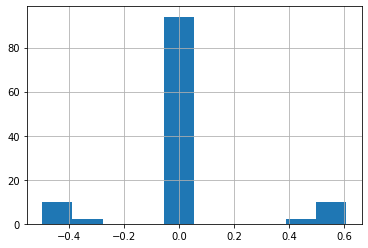

In [20]:
df["diff"].hist();

In most cases there is little or no difference in the probabilities for the target relations.
However, some appear to be off by a substantial (`0.6`) amount, which indicates potential problems in this part of our graph data.

The following rows show where these `foaf:knows` annotations in the graph differs significantly from their truth values predicted by PSL:

In [21]:
df[df["diff"] >= 0.4]

,predicate,p1,p2,truth,diff
2,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_18,0.561153,0.561153
4,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_21,0.476654,0.476654
5,KNOWS,http://example.org/stuff/person_18,http://example.org/stuff/person_17,0.560540,0.560540
15,KNOWS,http://example.org/stuff/person_14,http://example.org/stuff/person_06,0.507943,0.507943
24,KNOWS,http://example.org/stuff/person_19,http://example.org/stuff/person_09,0.539348,0.539348
28,KNOWS,http://example.org/stuff/person_17,http://example.org/stuff/person_01,0.581051,0.581051
36,KNOWS,http://example.org/stuff/person_01,http://example.org/stuff/person_17,0.578490,0.578490
39,KNOWS,http://example.org/stuff/person_21,http://example.org/stuff/person_17,0.476276,0.476276
55,KNOWS,http://example.org/stuff/person_09,http://example.org/stuff/person_19,0.540269,0.540269
70,KNOWS,http://example.org/stuff/person_06,http://example.org/stuff/person_14,0.506647,0.506647


In most of these cases, the `truth` value is floating (somewhere near ~0.5) when it was expected to be zero (i.e., they don't know each other).
Part of that likely comes from the use of the `Likes` predicate with boolean values; the original demo had probabilities for those, but was simplified here.

Speaking of [*human-in-the-loop*](https://derwen.ai/d/human-in-the-loop) practices for AI, using PSL along with a KG seems like a great way to leverage machine learning, so that the people can focus on parts of the graph that have the most uncertainty.
And, therefore, probably provide the best ROI for investing time+cost into curation.

---

## Exercises

**Exercise 1:**

Build a PSL model that tests the "noodle vs. pancake" rules used in an earlier example with our recipe KG.
Which recipes should be annotated differently?

**Exercise 2:**

Try representing one of the other [PSL examples](https://github.com/linqs/psl-examples/) using RDF and `kglab`.